In [7]:
import numpy as np
import math
from math import pi
from matplotlib import pyplot as plt

import qiskit
from qiskit import QuantumCircuit, transpile,  assemble
from qiskit_aer import AerSimulator,Aer

from qiskit.visualization import *

from qiskit import ClassicalRegister, QuantumRegister, transpile
#from qiskit.tools.visualization import circuit_drawer
from qiskit.visualization import circuit_drawer
from qiskit.quantum_info import state_fidelity, Statevector, SparsePauliOp, Operator
#from qiskit import BasicAer

from qiskit.quantum_info.operators import Operator, Pauli

import qiskit_ibm_provider
import qiskit.quantum_info as qi

import itertools
from itertools import combinations

from qiskit import *

# Need gate classes for generating the Pauli twirling sets
from qiskit.circuit.library import (IGate, XGate, YGate, ZGate,
                                    CXGate, CZGate, ECRGate, iSwapGate,QFT, RYGate, RZGate)

# Classes for building up a directed-acyclic graph (DAG) structure
from qiskit.circuit import QuantumRegister,Parameter, ParameterVector, CircuitInstruction
from qiskit.dagcircuit import DAGCircuit

# Transpiler stuff needed to make a pass and passmanager
from qiskit.transpiler import PassManager
from qiskit.transpiler.basepasses import TransformationPass
from qiskit.transpiler.passes import Optimize1qGatesDecomposition,CommutativeCancellation,CXCancellation,Optimize1qGatesSimpleCommutation

In [45]:
%run SetUp.ipynb

In [8]:
angles_from_vqe = [-0.17752535, -0.04847123]

In [9]:
nQ = 6 # nq needs to be even
# m = 0.5
# g = math.sqrt(m*16/3)
m = 1.
g = 2.

## Initialize Vacuum

In [10]:
# prototype. activate nl links in the middle of the circuit

def activate(nl, nq = nQ, cir = None):
    if nq <= nl: raise Exception (" Size of system needs to be bigger than the number of links being activated. ")
    if cir == None: cir = QuantumCircuit(nq)
    loc = (nq-nl) // 2
    for i in range(nl):
        cir.x(loc+i)
    return cir

In [29]:
# apply the VQE that initialize the circuit into true vacuum to circuit

def true_vac(angles = angles_from_vqe, nq = nQ, cir = None):
    if cir == None: cir = QuantumCircuit(nq)
    
    # even index operations
    for i in range(nq//2): # odd sites go to y basis
        cir.sdg(2*i+1)
        cir.h(2*i+1)    
    for i in range(nq//2):
        cir.rz((angles[0]+angles[1])/2, 2*i+1) # applying the single y gate
        cir.cx(2*i+1, (2*i+2)%nq)                      # applying IYZ
        cir.rz((angles[0]- angles[1])/2, (2*i+2)%nq)
        cir.cx(2*i+1, (2*i+2)%nq)
    for i in range(nq//2):   # applying ZYI, CNOT on the right cancelled with CNOT in ZYZ
        cir.cx(2*i, 2*i+1)                      
        cir.rz((angles[0] - angles[1])/2, 2*i+1)
    for i in range(nq//2):  # applying ZYZ, CNOT on the left cancelled
        cir.cx(2*i+1, (2*i+2)%nq)
        cir.rz((angles[0] + angles[1])/2, (2*i+2)%nq)
        cir.cx(2*i+1, (2*i+2)%nq)
        cir.cx(2*i, 2*i+1)  
    for i in range(nq//2): # odd sites go to y basis
        cir.h(2*i+1)   
        cir.s(2*i+1)
    
    #cir.barrier() # for visualization purposes
     
    # odd index operations
    for i in range(nq//2): # even sites go to y basis
        cir.sdg(2*i)
        cir.h(2*i)  
    for i in range(nq//2):
        cir.rz((angles[0]+angles[1])/2, 2*i) # applying the single y gate
        cir.cx(2*i, (2*i+1)%nq)                      # applying IYZ
        cir.rz((angles[0]- angles[1])/2, (2*i+1)%nq)
        cir.cx(2*i, (2*i+1)%nq)  
    for i in range(nq//2):   # applying ZYI, CNOT on the right cancelled with CNOT in ZYZ
        cir.cx(2*i+1, (2*i+2)%nq)                      
        cir.rz((angles[0] - angles[1])/2, (2*i+2)%nq)
    for i in range(nq//2):  # applying ZYZ, CNOT on the left cancelled
        cir.cx((2*i+2)%nq, (2*i+3)%nq)
        cir.rz((angles[0] + angles[1])/2, (2*i+3)%nq)
        cir.cx((2*i+2)%nq, (2*i+3)%nq)
        cir.cx(2*i+1, (2*i+2)%nq)
    for i in range(nq//2): # even sites go to y basis
        cir.h(2*i)
        cir.s(2*i)
        
    return cir

## Construct Hamiltonian for QC

In [127]:
from math import sqrt


def exp_hkin_even(t, nq = nQ, cir = None):
    if cir == None: cir = QuantumCircuit(nq)
    angles = (1/math.sqrt(2),1/(2* math.sqrt(2)))
    for i in range(nq//2): # odd sites go to x basis
        cir.h(2*i+1)    
    for i in range(nq//2):
        cir.rz((angles[0]+angles[1])*t/2, 2*i+1) # applying the single x gate
        cir.cx(2*i+1, (2*i+2)%nq)                      # applying IXZ
        cir.rz((angles[0]- angles[1])*t/2, (2*i+2)%nq)
        cir.cx(2*i+1, (2*i+2)%nq)
    for i in range(nq//2):   # applying ZXI, CNOT on the right cancelled with CNOT in ZXZ
        cir.cx(2*i, 2*i+1)                      
        cir.rz((angles[0] - angles[1])*t/2, 2*i+1)
    for i in range(nq//2):  # applying ZXZ, CNOT on the left cancelled
        cir.cx(2*i+1, (2*i+2)%nq)
        cir.rz((angles[0] + angles[1])*t/2, (2*i+2)%nq)
        cir.cx(2*i+1, (2*i+2)%nq)
        cir.cx(2*i, 2*i+1)  
    for i in range(nq//2): # odd sites go to x basis
        cir.h(2*i+1)   
    return cir

def exp_hkin_odd(t, nq = nQ, cir = None):
    if cir == None: cir = QuantumCircuit(nq)
    angles = (1/math.sqrt(2),1/(2* math.sqrt(2)))
    for i in range(nq//2): # even sites go to x basis
        cir.h(2*i)  
    for i in range(nq//2):
        cir.rz((angles[0]+angles[1])*t/2, 2*i) # applying the single x gate
        cir.cx(2*i, (2*i+1)%nq)                      # applying IXZ
        cir.rz((angles[0]- angles[1])*t/2, (2*i+1)%nq)
        cir.cx(2*i, (2*i+1)%nq)  
    for i in range(nq//2):   # applying ZXI, CNOT on the right cancelled with CNOT in ZXZ
        cir.cx(2*i+1, (2*i+2)%nq)                      
        cir.rz((angles[0] - angles[1])*t/2, (2*i+2)%nq)
    for i in range(nq//2):  # applying ZXZ, CNOT on the left cancelled
        cir.cx((2*i+2)%nq, (2*i+3)%nq)
        cir.rz((angles[0] + angles[1])*t/2, (2*i+3)%nq)
        cir.cx((2*i+2)%nq, (2*i+3)%nq)
        cir.cx(2*i+1, (2*i+2)%nq)
    for i in range(nq//2): # even sites go to x basis
        cir.h(2*i)
    return cir

In [48]:
def exp_hm(t, nq = nQ, cir = None):
    if cir == None: cir = QuantumCircuit(nq)
    for i in range(nq):
        cir.cx(i, (i+1)%nq)
        cir.rz(-m*t, (i+1)%nq)
        cir.cx(i, (i+1)%nq)
    return cir

In [49]:
def exp_he(t, nq = nQ, cir = None):
    if cir == None: cir = QuantumCircuit(nq)
    for i in range(nq):
        cir.rz(-3*t*g**2/8,i)
    return cir

### Tests

In [130]:
hk_cir = exp_hkin_even(0)

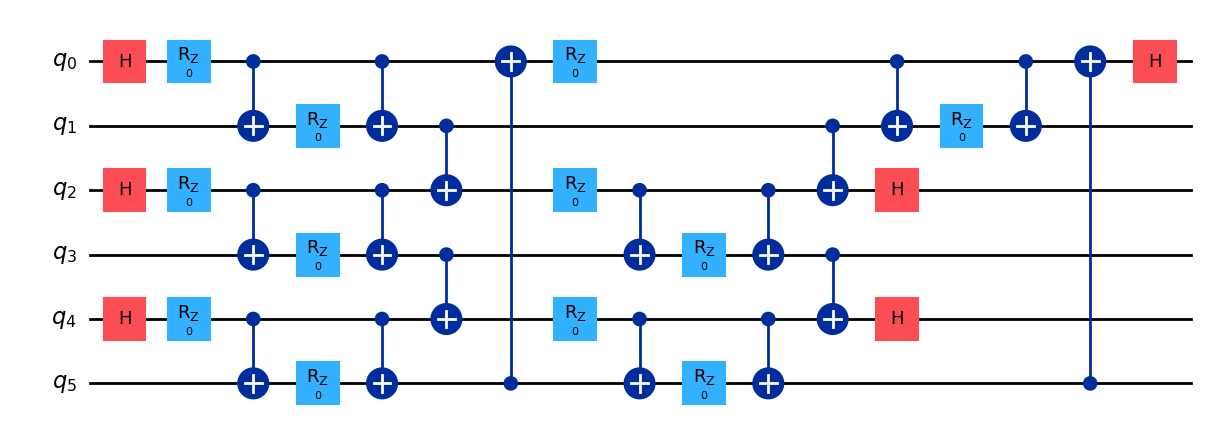

In [129]:
hk_cir.draw('mpl')

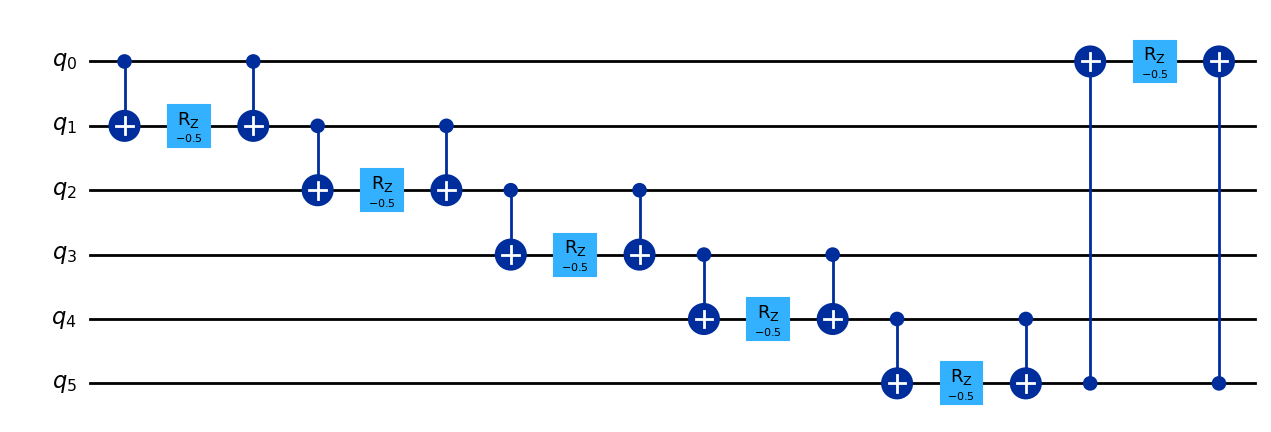

In [11]:
HM_cir = exp_hm(1)
HM_cir.draw('mpl')

## Time Evolution

In [38]:
def trotter_step(dt, nq = nQ, cir = None):
    if cir == None: cir = QuantumCircuit(nq)
    exp_hkin_odd(dt/2, nq, cir) # can save cost by preconstructing kin_odd and kin_even and do cir.compose(kin_odd)
    exp_hkin_even(dt/2, nq, cir) # leaving as is for now until it is required to save compilation time
    exp_hm(dt, nq, cir)
    exp_he(dt, nq, cir)
    exp_hkin_even(dt/2, nq, cir)
    exp_hkin_odd(dt/2, nq, cir)
    return cir

In [39]:
def time_ev(dt,steps, nq = nQ, cir = None):
    if cir == None: cir = QuantumCircuit(nq)
    for i in range(steps):
        trotter_step(dt, nq, cir)
    return cir

## Examine Vacuum time evolution to find a small enough dt

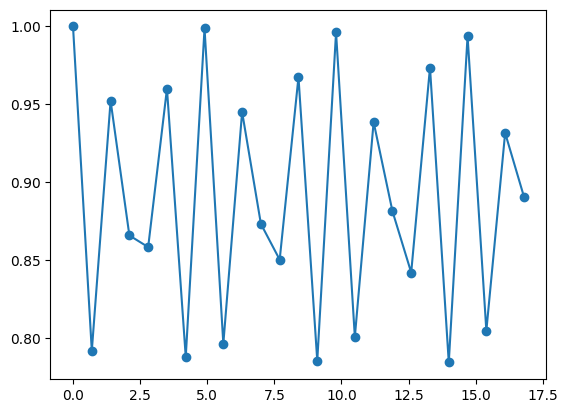

In [140]:
del_t = 0.7
overlaps = []

for i in range(25):
    vac_cir = true_vac(angles_from_vqe)
    result_state = Statevector.from_int(0, 2**nQ)
    result_state = result_state.evolve(time_ev(del_t, i, nQ, vac_cir))
    overlaps.append(qiskit.quantum_info.state_fidelity(result_state,mathematica_result_6_SU2))
    
plt.plot(np.arange(0, 16.8, 0.7),overlaps, 'o-')

# Run

In [ ]:
# Initialize the circuit with 3 links activated 
circir = QuantumCircuit(nQ)
activate(3,nQ,circir)
true_vac(angles_from_vqe,nQ,circir)

# Time evolution circuits
